# Machine Learning: Gaussian Naive Bayes

## ¿Comprar o alquilar casa? ¿Qué me conviene?

En este ejercicio, usaremos el algoritmo de Gaussian Naive Bayes para decidir si nos conviene Alguilar o Comprar una casa 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sb

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9) # tamaño en pixeles
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore") #ignora mensajes de advertencia

#librerias para el modelo:
from sklearn.model_selection import train_test_split #hacer la division del conjunto de datos, de entrenamiento y prueba
from sklearn.metrics import classification_report #para las metricas
from sklearn.metrics import confusion_matrix #matriz de confusion: elemento critico para Modelos de clasificacion (verdadero positivo, ...)
from sklearn.naive_bayes import GaussianNB #modelo Gaussiano
from sklearn.feature_selection import SelectKBest #seleccion de mejores caracteristicas

## Importemos Datos de entrada

In [ ]:
dataframe = pd.read_csv("./Data/comprar_alquilar.csv")
dataframe.head(7)

,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,comprar
0,6000,1000,0,600,50000,400000,0,2,2,1
1,6745,944,123,429,43240,636897,1,3,6,0
2,6455,1033,98,795,57463,321779,2,1,8,1
3,7098,1278,15,254,54506,660933,0,0,3,0
4,6167,863,223,520,41512,348932,0,0,3,1
5,5692,911,11,325,50875,360863,1,4,5,1
6,6830,1298,345,309,46761,429812,1,1,5,1


 REFERENCIAS para entender las columnas:
- Ingresos y gastos son mensuales, de 1 personas o 2 si están casados.
- Estado_civil: 0-soltero, 1-casado, 2-divorciado
- Trabajo: 0-sin trabajo, 1-autonomo, 2-asalariado, 3-empresario, 4-Autonomos, 5-Asalariados, 6-Autonomo y Asalariado, 7-Empresario y Autonomo, 8 Empresarios o empresario y autónomo
- Hijos: Cantidad de hijos menores (no trabajan)
- Comprar: 0-Mejor alquilar casa, 1-Comprar casa
- hipoteca fija a 30 años con interes (no se tomo en cuenta, pero estaba)

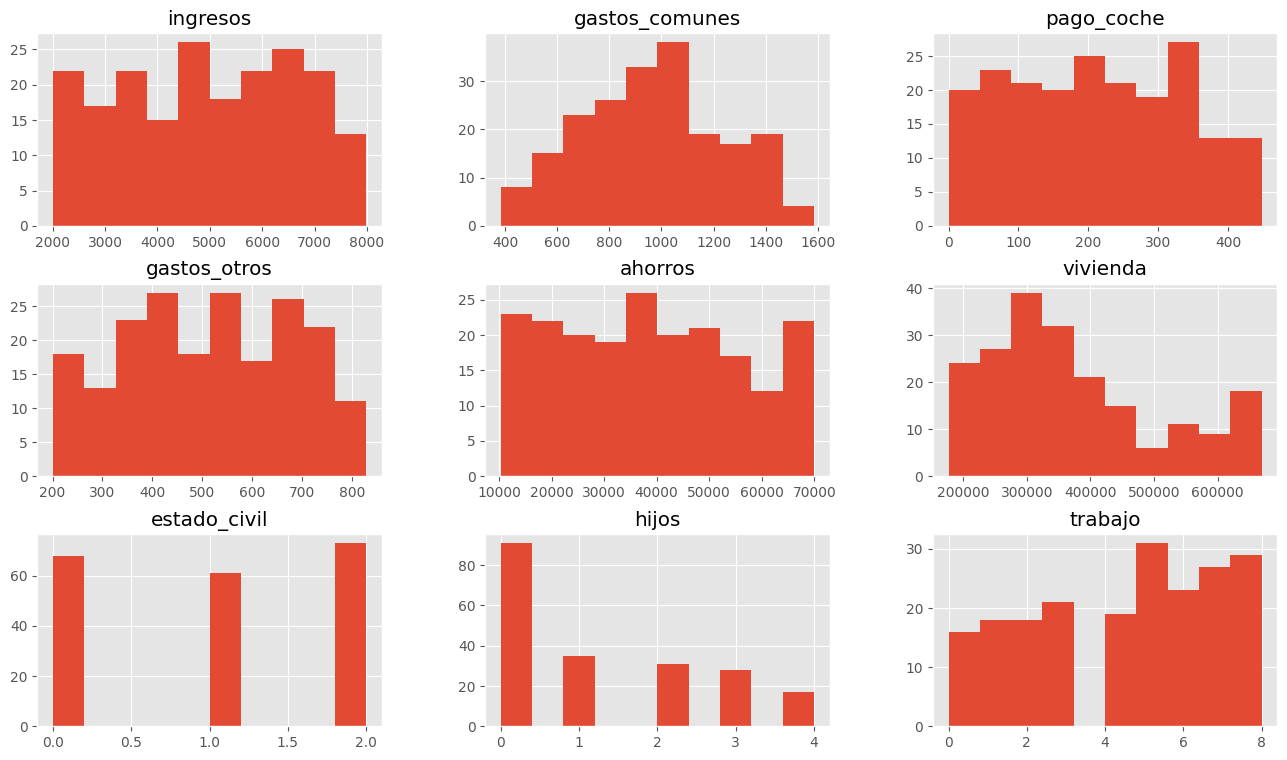

In [3]:
dataframe.drop(['comprar'], axis=1).hist() #se dropea "comprar" en la visualizacion porque es el factor booleano
plt.show()

# Preprocesamiento de los datos

Creamos 2 columnas nuevas. En una agrupamos los gastos mensuales. En la otra el monto a financiar para comprar la casa

In [4]:
dataframe['gastos']=(dataframe['gastos_comunes']+dataframe['gastos_otros']+dataframe['pago_coche'])
dataframe['financiar']=dataframe['vivienda']-dataframe['ahorros']
dataframe.drop(['gastos_comunes','gastos_otros','pago_coche'], axis=1) #IMPORTANTE: esto me permite mostrar el dataframe con las columnas eliminadas, pero no las ha eliminado del dataframe

,ingresos,ahorros,vivienda,estado_civil,hijos,trabajo,comprar,gastos,financiar
0,6000,50000,400000,0,2,2,1,1600,350000
1,6745,43240,636897,1,3,6,0,1496,593657
2,6455,57463,321779,2,1,8,1,1926,264316
3,7098,54506,660933,0,0,3,0,1547,606427
4,6167,41512,348932,0,0,3,1,1606,307420
...,...,...,...,...,...,...,...,...,...
197,3831,10723,363120,0,0,2,0,1530,352397
198,3961,21880,280421,2,3,8,0,1775,258541
199,3184,35565,388025,1,3,8,0,1915,352460
200,3334,19985,376892,1,2,5,0,1888,356907


### Información estadística de los datos

In [5]:
reduced = dataframe.drop(['gastos_comunes','gastos_otros','pago_coche'], axis=1) #axis=1: se refiere a eliminar las columnas
reduced.describe()

,ingresos,ahorros,vivienda,estado_civil,hijos,trabajo,comprar,gastos,financiar
count,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,4958.995050,38749.668317,373349.638614,1.024752,1.232673,4.490099,0.331683,1698.752475,334599.970297
std,1682.862556,17365.231870,136371.525622,0.837184,1.367833,2.535794,0.471988,324.838005,126607.099497
min,2008.000000,10319.000000,176553.000000,0.000000,0.000000,0.000000,0.000000,1007.000000,154716.000000
25%,3513.750000,24964.250000,274810.000000,0.000000,0.000000,2.000000,0.000000,1430.500000,240410.250000
50%,4947.500000,38523.000000,340783.500000,1.000000,1.000000,5.000000,0.000000,1669.500000,301177.000000
75%,6374.500000,52150.750000,444482.000000,2.000000,2.000000,7.000000,1.000000,1928.000000,393413.000000
max,7984.000000,69934.000000,669540.000000,2.000000,4.000000,8.000000,1.000000,2543.000000,618621.000000


## Selección de las características (Feature Selection)
Selección de las características de entrada... Esto se hace de manera automatizada con SelectKBest

### Veamos la correlación entre columnas

<Axes: title={'center': 'Caracteristicas de correlacion de Pearson'}>

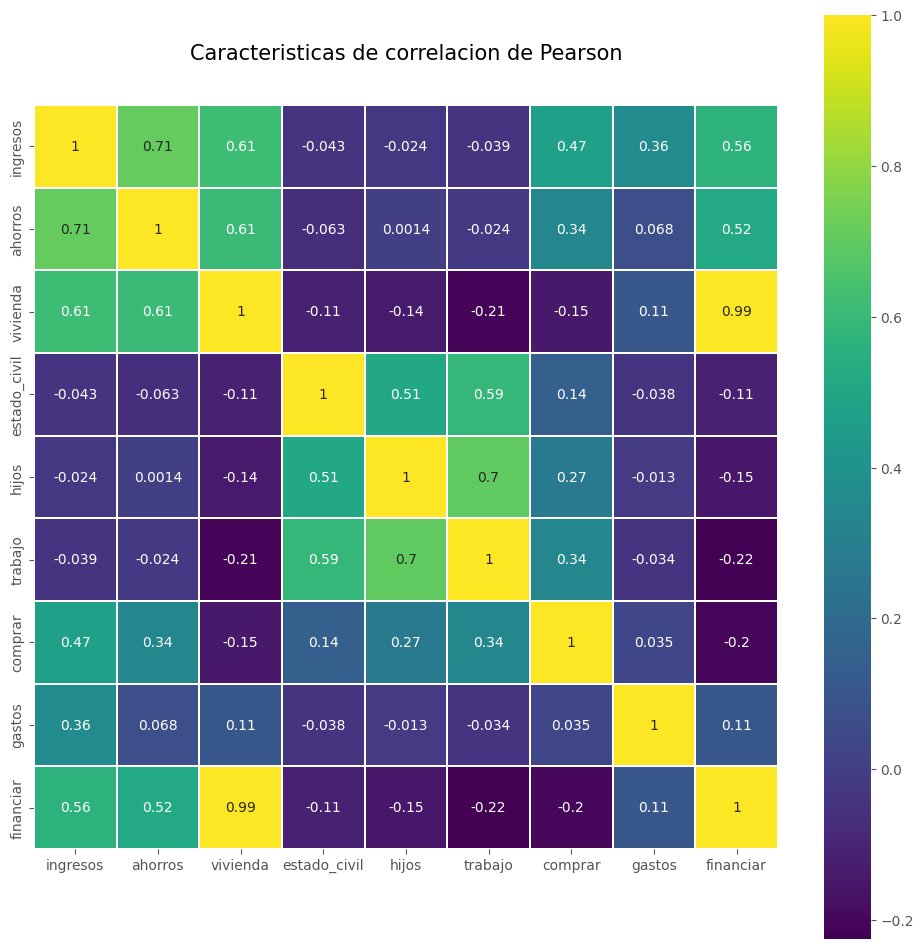

In [6]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Caracteristicas de correlacion de Pearson', y=1.05, size=15)
sb.heatmap(reduced.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True) #aqui ya tomamos en cuenta al dataframe 'reduced'

Usemos la clase SelectKBest de SkLearn para elegir las 5 mejores características a usar.

In [7]:
#aqui trabajamos con el dataframe original 'dataframe'
X=dataframe.drop(['comprar'], axis=1) #nuevo dataframe X
y=dataframe['comprar'] #nuevo dataframe y

best=SelectKBest(k=5) #SelectKBest selecciona las 5 características más importantes 
X_new = best.fit_transform(X, y) #aqui el modelo aprende, X_new es el DataFrame con solo las 5 mejores características en base a su relación con y
X_new.shape #IMPORTANTE, el X_new solo lo estamos usando para mostrar el shape, la selección de características ya ha ocurrido internamente en best.fit_transform(X, y)

(202, 5)

In [8]:
selected = best.get_support(indices=True) #Usando get_support(), se obtienen los índices y nombres de las características seleccionadas
print(X.columns[selected])

Index(['ingresos', 'ahorros', 'hijos', 'trabajo', 'financiar'], dtype='object')


Veamos la correlación entre las 5 mejores Features

In [9]:
used_features = X.columns[selected]

<Axes: title={'center': 'Pearson Correlation of Features'}>

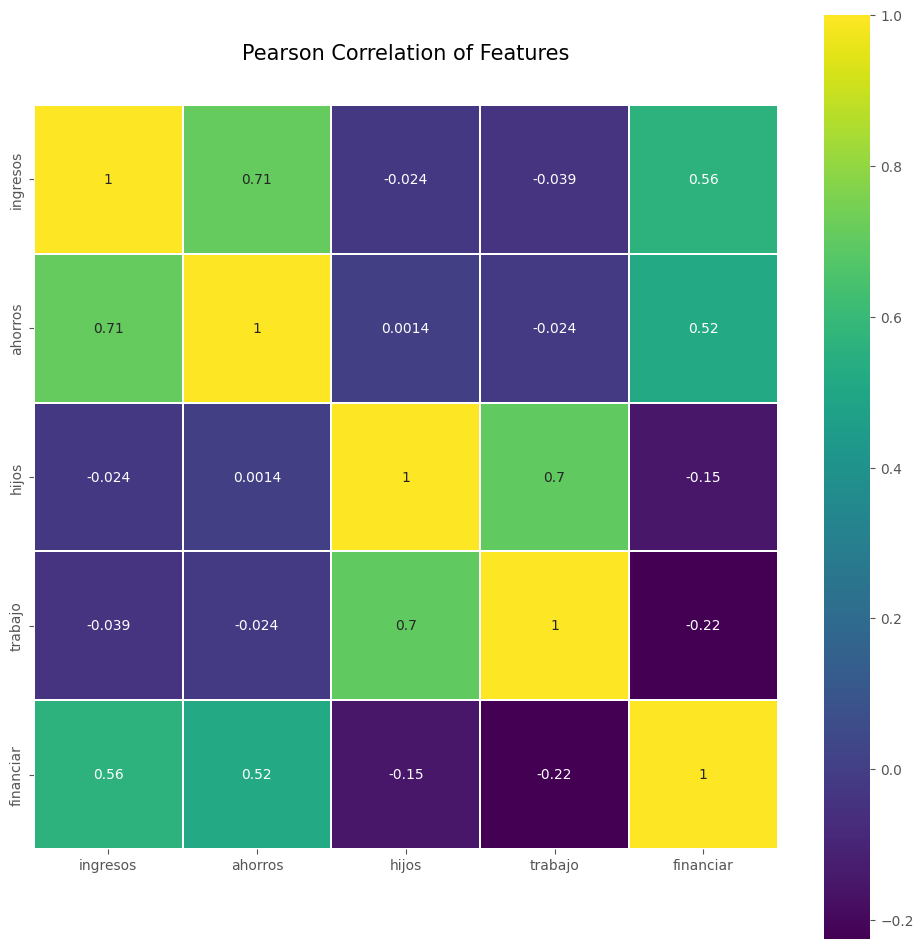

In [10]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sb.heatmap(dataframe[used_features].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

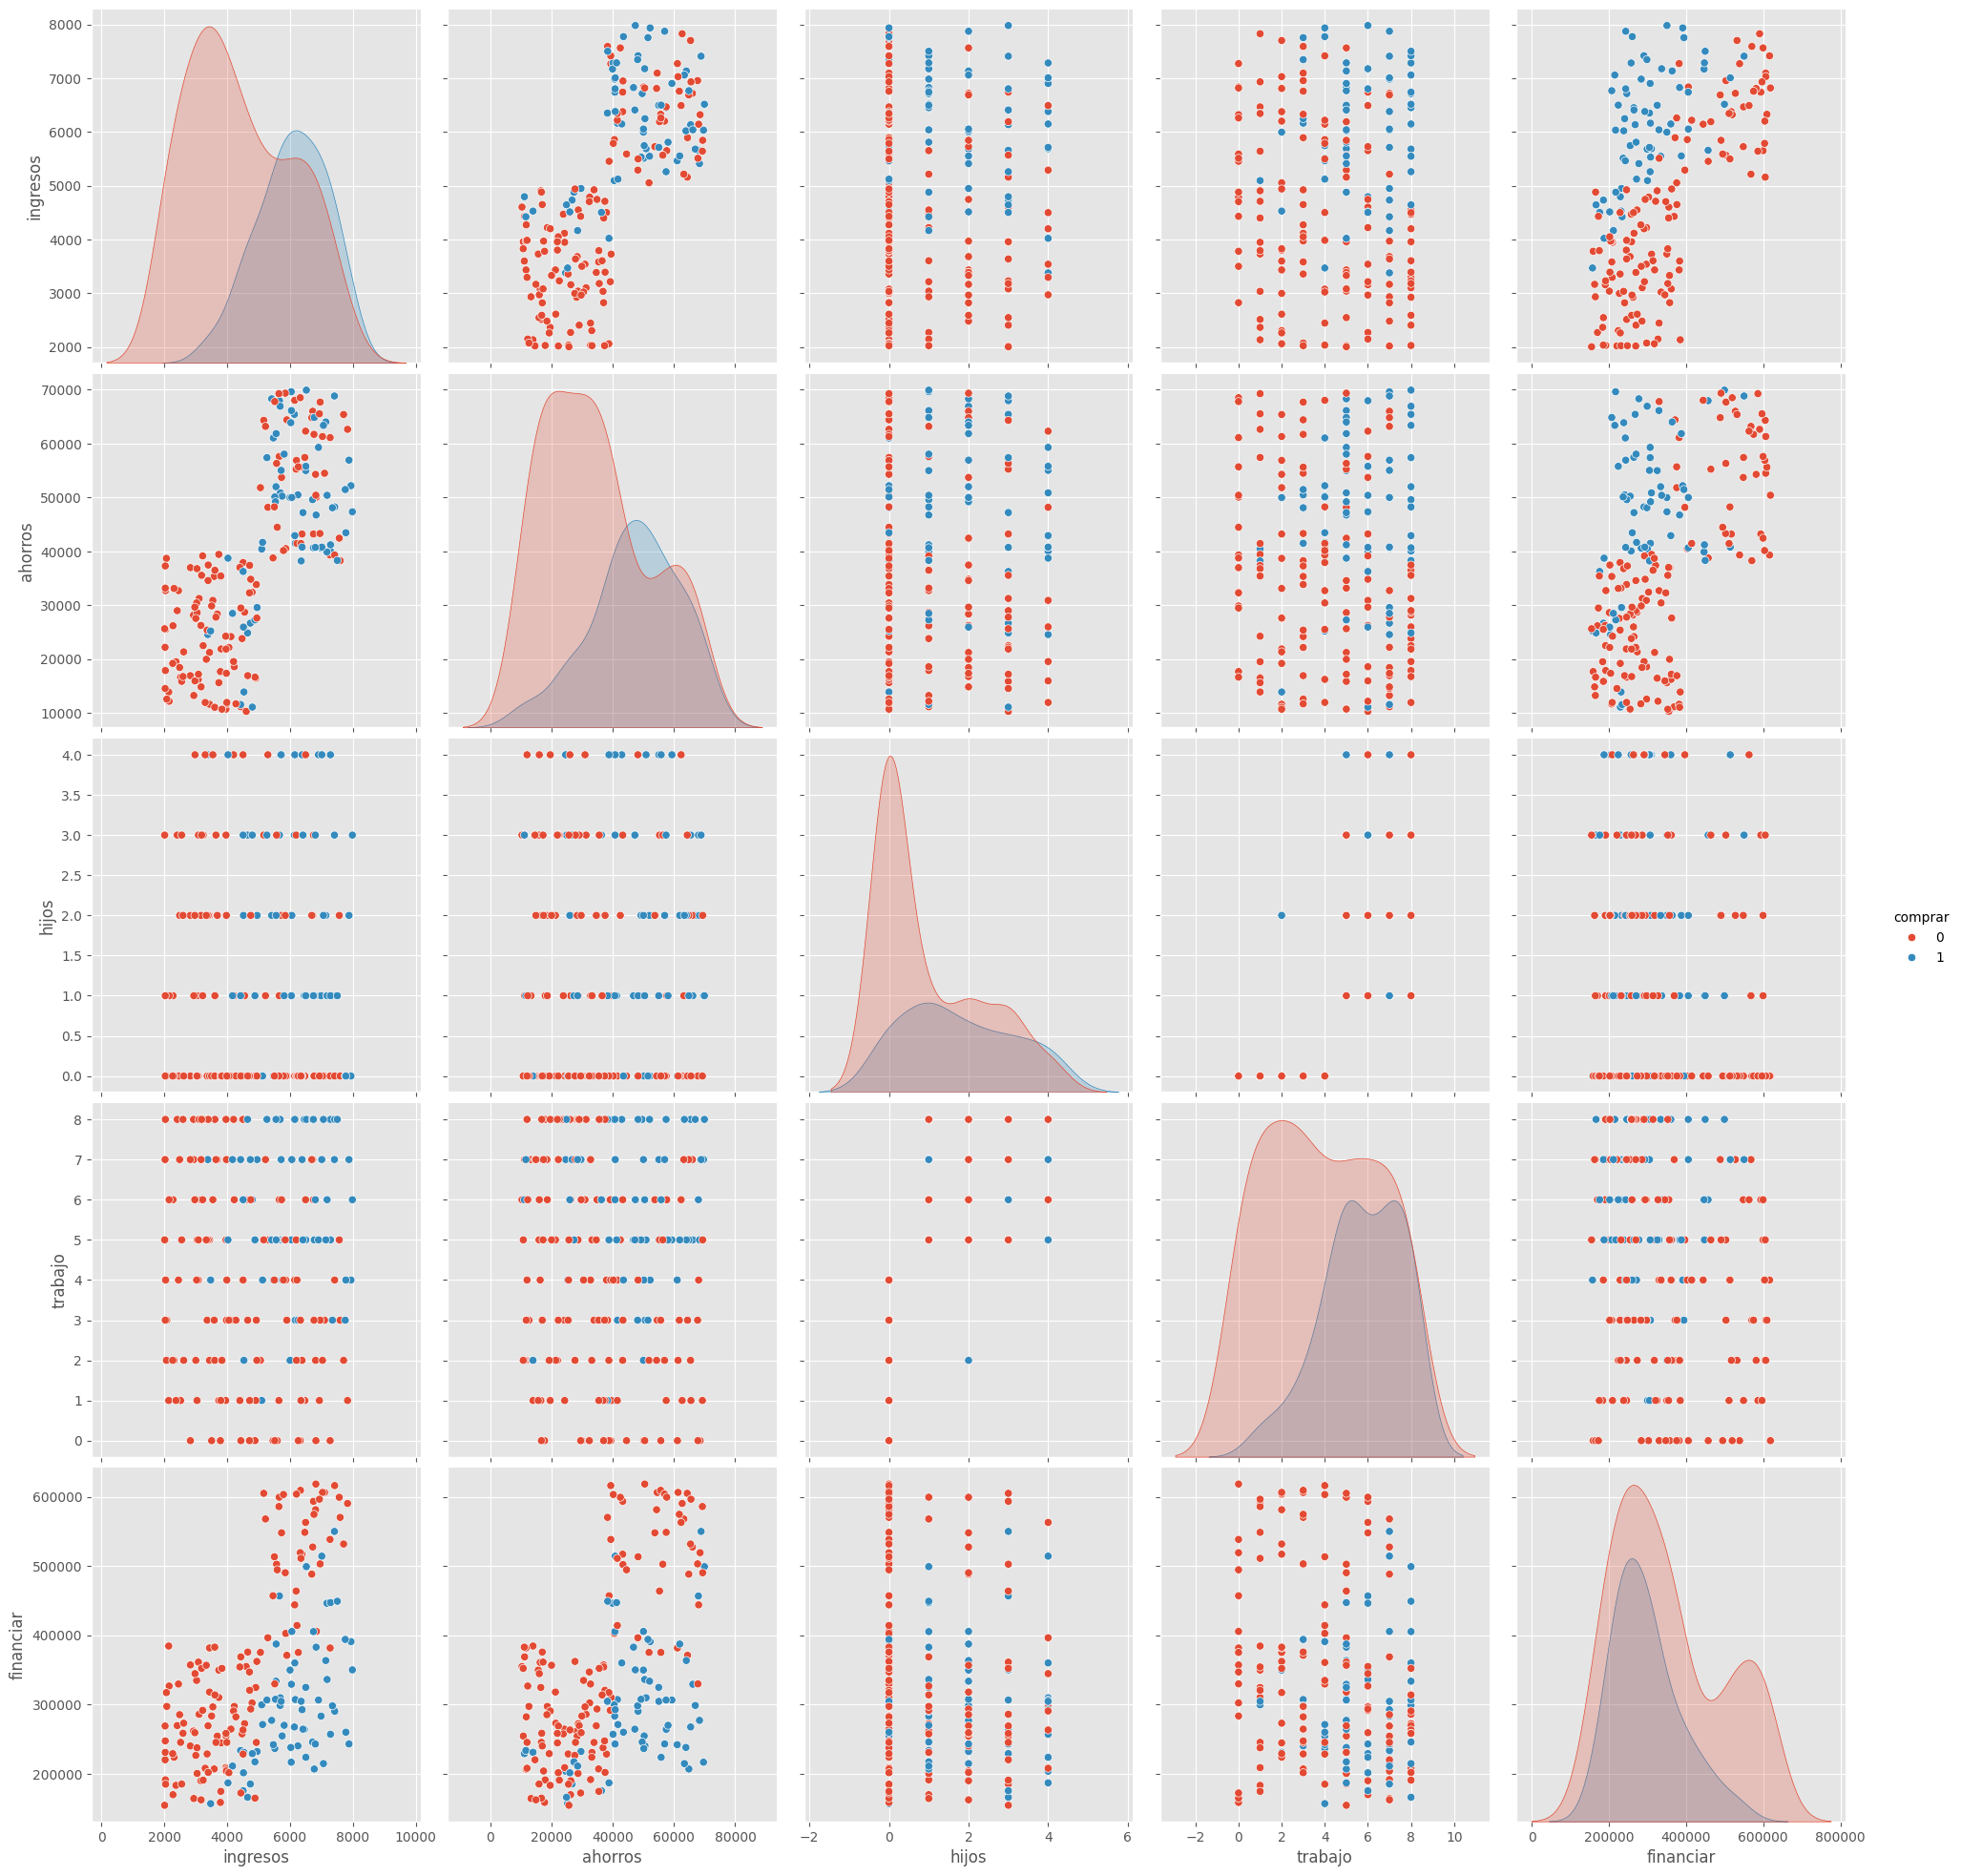

In [11]:
sb.pairplot(dataframe, hue='comprar',height=4,vars=used_features,kind='scatter')

# Creamos el modelo de Gaussian Naive Bayes

Dividimos en un set de Entrenamiento y otro de Test con el 20% de las entradas

In [12]:
X_train, X_test = train_test_split(dataframe, test_size=0.2, random_state=42)

In [13]:
X_train

,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,comprar,gastos,financiar
199,3184,955,276,684,35565,388025,1,3,8,0,1915,352460
38,6025,964,187,567,63892,302117,1,2,5,1,1718,238225
24,5099,867,73,336,40451,340230,0,0,1,1,1276,299779
122,7138,1356,27,209,64027,427780,1,2,5,1,1592,363753
197,3831,690,352,488,10723,363120,0,0,2,0,1530,352397
...,...,...,...,...,...,...,...,...,...,...,...,...
106,6205,1179,240,729,56904,661009,0,0,2,0,2148,604105
14,7567,1059,341,339,42462,641963,2,2,5,0,1739,599501
92,4426,1328,152,480,11593,245454,2,1,7,1,1960,233861
179,2028,690,167,325,37309,284984,2,0,3,0,1182,247675


In [14]:
y_train = X_train["comprar"]
y_test = X_test["comprar"]

In [15]:
X_train

,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,comprar,gastos,financiar
199,3184,955,276,684,35565,388025,1,3,8,0,1915,352460
38,6025,964,187,567,63892,302117,1,2,5,1,1718,238225
24,5099,867,73,336,40451,340230,0,0,1,1,1276,299779
122,7138,1356,27,209,64027,427780,1,2,5,1,1592,363753
197,3831,690,352,488,10723,363120,0,0,2,0,1530,352397
...,...,...,...,...,...,...,...,...,...,...,...,...
106,6205,1179,240,729,56904,661009,0,0,2,0,2148,604105
14,7567,1059,341,339,42462,641963,2,2,5,0,1739,599501
92,4426,1328,152,480,11593,245454,2,1,7,1,1960,233861
179,2028,690,167,325,37309,284984,2,0,3,0,1182,247675


Entrenamos el modelo

In [16]:
gnb = GaussianNB()

gnb.fit(
    X_train[used_features].values,
    y_train
)

GaussianNB()

In [17]:
y_pred = gnb.predict(X_test[used_features])

# Resultados

In [18]:
print('Precisión en el set de Entrenamiento: {:.2f}'.format(gnb.score(X_train[used_features], y_train)))
print('Precisión en el set de Test: {:.2f}'.format(gnb.score(X_test[used_features], y_test)))

Precisión en el set de Entrenamiento: 0.88
Precisión en el set de Test: 0.80


In [19]:
print("Total de Muestras en Test: {}\nFallos: {}".format(
        X_test.shape[0],
        (y_test != y_pred).sum()
))

Total de Muestras en Test: 41
Fallos: 8


In [20]:
print(confusion_matrix(y_test, y_pred))
#en base al orden de y_test, y_pred, se tiene:
#verdadero positivo | falso negativo
#falso positivo     | verdadero negativo

[[24  0]
 [ 8  9]]


In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86        24
           1       1.00      0.53      0.69        17

    accuracy                           0.80        41
   macro avg       0.88      0.76      0.77        41
weighted avg       0.85      0.80      0.79        41



## Nuevas Predicciones

Hagamos 2 pruebas a modo de ejemplo en las que el algoritmo nos recomienda Alquilar (0) y Comprar (1) en el 2do caso

In [22]:
#                 ['ingresos', 'ahorros', 'hijos', 'trabajo', 'financiar']
print(gnb.predict([[2000,        5000,     0,       5,         200000],
                   [6000,        34000,    2,       5,         320000] ]))
#Resultado esperado 0-Alquilar, 1-Comprar casa

[0 1]
